# Image Processing

This notebook shows some exemplary image processing algorithms. Note that plotting methods should always be called after preprocessing modules. `ds.pp.threshold(0.99).pl.colorize('red').pl.show()` will work, whereas `ds.pl.colorize('red').pp.threshold(0.99).pl.show()` will not show the thresholded image correctly.

In [1]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [2]:
# loading in a data set and performing some formatting for convenience
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK.zarr')
ds["_properties"] = ds["_labels"]
ds = ds.pp.drop_layers("_labels")
# focusing on just one channel to illustrate the concepts better
ds_single_channel = ds.pp['IKZF3']
ds_multichannel = ds.pp[['PAX5', 'CD3']]
ds

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:        (cells: 12560, channels: 56, y: 3000, x: 3000, features: 4,
                    labels: 8, props: 2)
Coordinates:
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * features       (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels         (labels) int64 1 2 3 4 5 6 7 8
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _arcsinh_mean  (cells, channels) float64 3.111 0.0 1.391 ... 1.324 0.4174
    _arcsinh_sum   (cells, channels) float64 8.346 0.0 6.564 ... 6.625 5.224
    _image         (channels, y, x) uint8 4 4 4 4 5 4 4 3 4 ... 2 2 2 2 2 2 2 2
    _obs           (cells, features) float64 613.3 768.4 4.0 ... 8.0 7.0
    _raw_mean      (cells, channels) float64 56.02 0.0 9.426 ... 8.727 2.148
    _raw_sum       (cells, channels) float64 1.053e+04 0.0 ... 1.885e+03 464.0
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _properties    (labels, props) object 'C3' ... 'B (PAX5)'

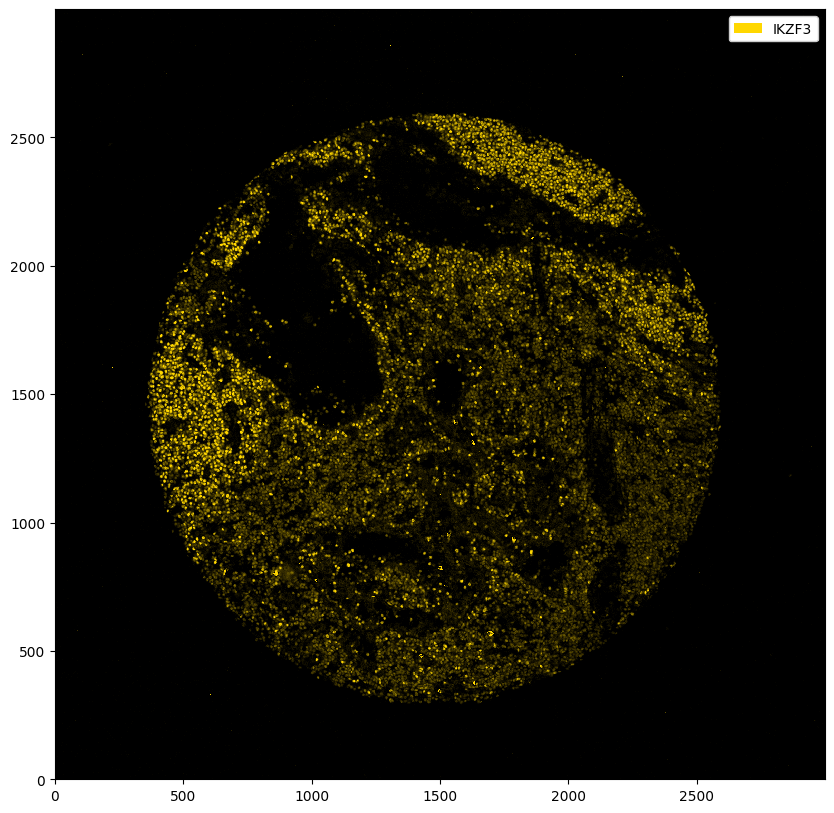

In [3]:
plt.figure(figsize=(10, 10))
_ = ds_single_channel.pl.colorize('gold').pl.show()

The marker above seems to have worked fairly well, but you can observe some unspecific binding. To boost the signal-to-noise ratio, we can threshold the image. This basically means that every value below that threshold gets set to zero. You can either threshold using an absolute intensity, or using a quantile value.

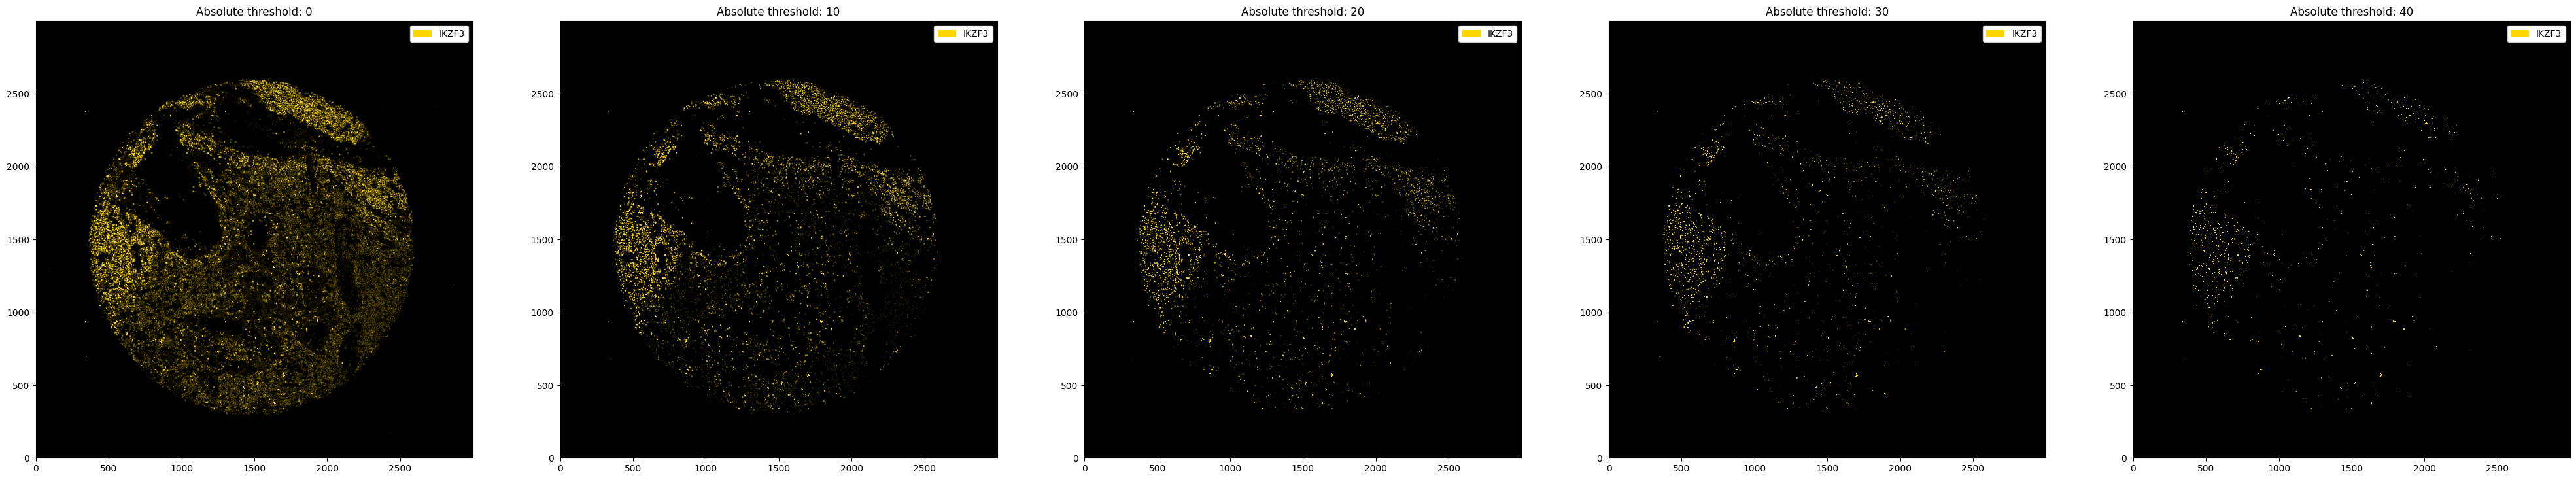

In [4]:
# thresholding with absolute intensity
fig, ax = plt.subplots(1, 5, figsize=(50, 10))

for i in range(5):
    _ = ds_single_channel.pp.threshold(intensity= 10*i).pl.colorize('gold').pl.show(ax=ax[i])
    ax[i].set_title(f"Absolute threshold: {10 * i}")

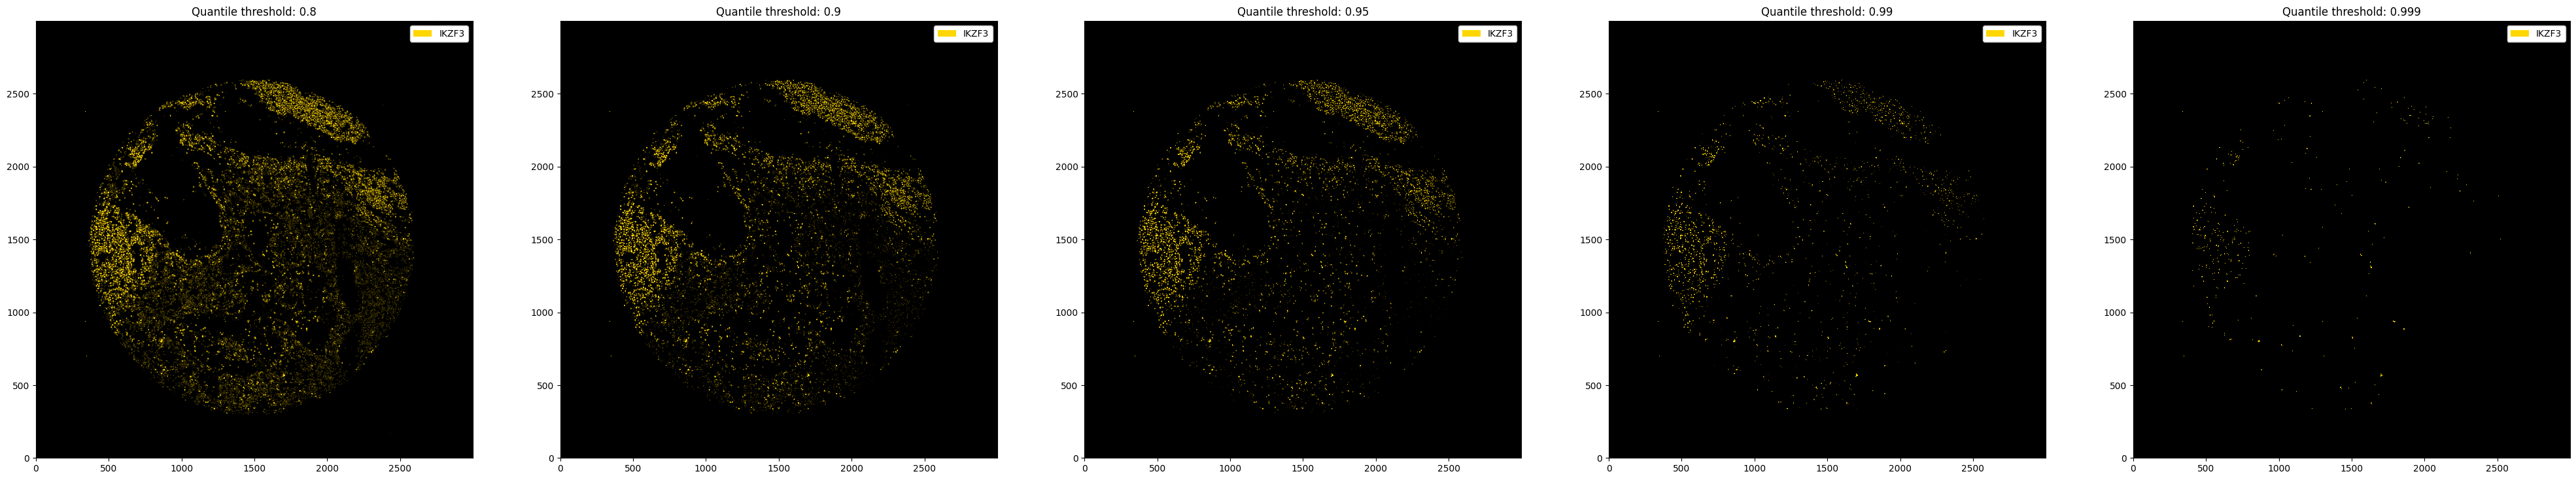

In [5]:
# thresholding with quantiles
fig, ax = plt.subplots(1, 5, figsize=(50, 10))

for i, quantile in enumerate([0.8, 0.9, 0.95, 0.99, 0.999]):
    _ = ds_single_channel.pp.threshold(quantile= quantile).pl.colorize('gold').pl.show(ax=ax[i])
    ax[i].set_title(f"Quantile threshold: {quantile}")

You can also use different thresholds for different channels.

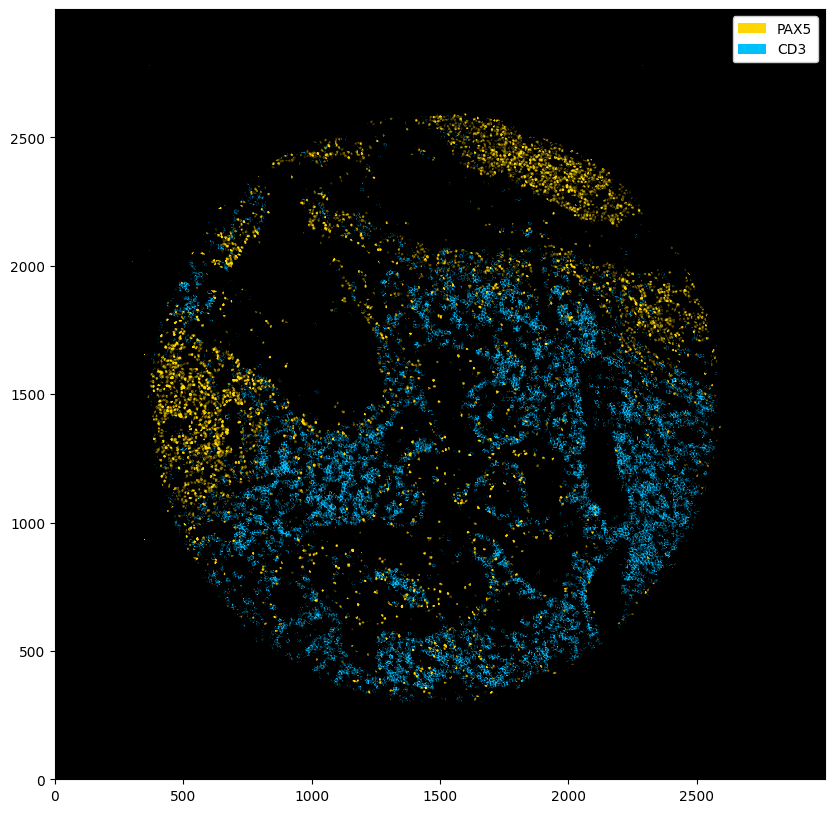

In [6]:
fig = plt.figure(figsize=(10, 10))
_ = ds_multichannel.pp.threshold(quantile=[0.95, 0.9]).pl.colorize(['gold', 'deepskyblue']).pl.show()

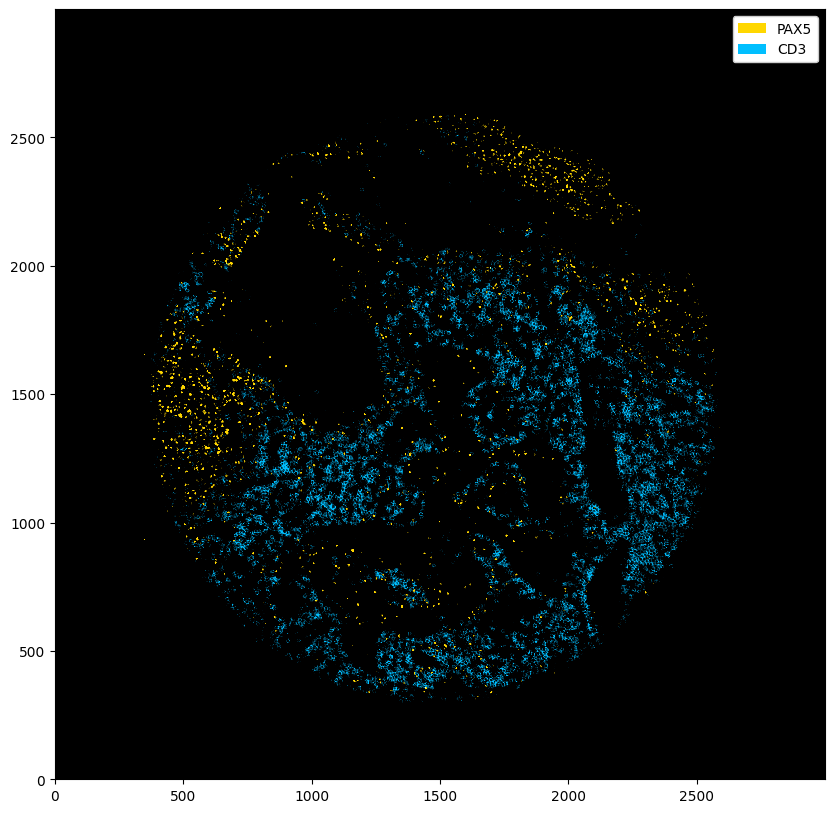

In [15]:
fig = plt.figure(figsize=(10, 10))
_ = ds_multichannel.pp.threshold(intensity=[20, 30]).pl.colorize(['gold', 'deepskyblue']).pl.show()

After thresholding, a medianfilter can be useful to reduce the noise further. This is implemented in the `pp.restore()` method.

Text(0.5, 1.0, 'Thresholded and restored')

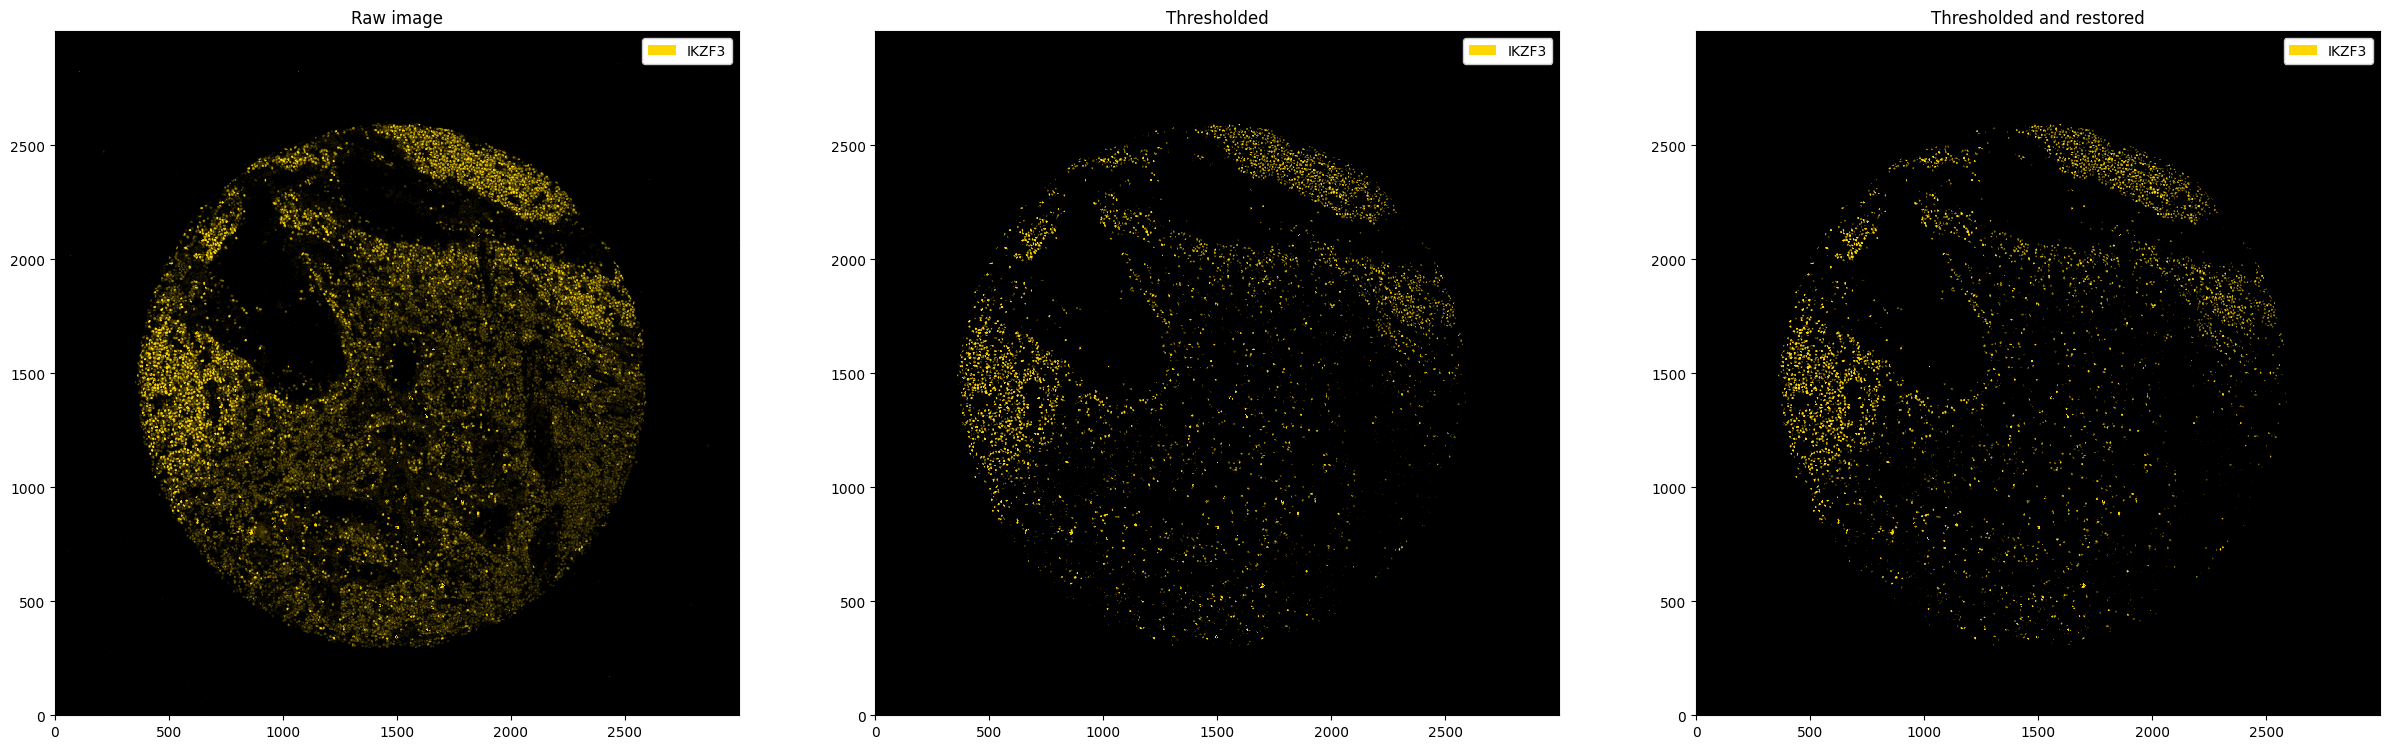

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_single_channel.pl.colorize('gold').pl.show(ax=ax[0])
_ = ds_single_channel.pp.threshold(quantile=0.95).pl.colorize('gold').pl.show(ax=ax[1])
_ = ds_single_channel.pp.threshold(quantile=0.95).pp.restore('medfilt2d', kernel_size=3).pl.colorize('gold').pl.show(ax=ax[2])

ax[0].set_title("Raw image")
ax[1].set_title("Thresholded")
ax[2].set_title("Thresholded and restored")

Next to thresholding and restoring, you can apply any preprocessing function you like using the `pp.apply()` method. With this method, you can provide existing (e. g. from `scipy` or `skimage`) or custom functions to your multichannel images.

Text(0.5, 1.0, 'Gaussian filter')

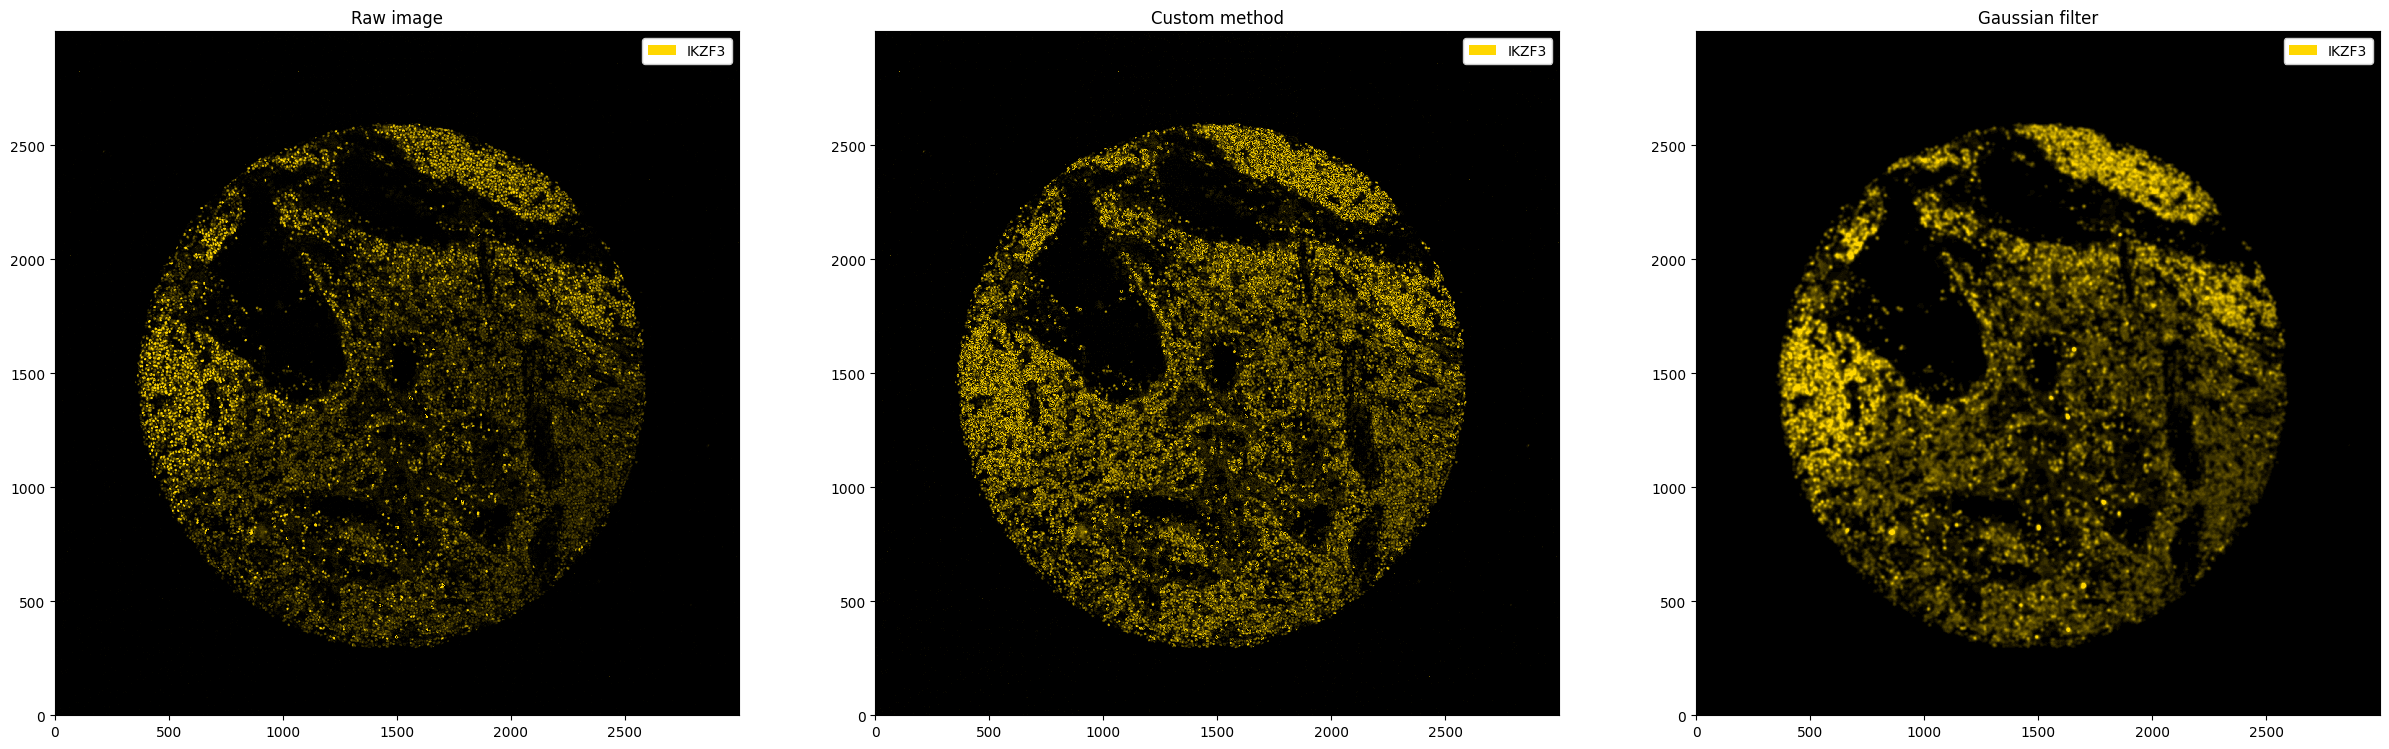

In [8]:
# application to a single channel
from scipy.ndimage import gaussian_filter

def multiply_array(arr, factor=10):
        return (arr * factor).clip(0, 255).astype('uint8')

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_single_channel.pl.colorize('gold').pl.show(ax=ax[0])
_ = ds_single_channel.pp.apply(func=multiply_array).pl.colorize('gold').pl.show(ax=ax[1])
_ = ds_single_channel.pp.apply(func=gaussian_filter, sigma=5).pl.colorize('gold').pl.show(ax=ax[2])

ax[0].set_title("Raw image")
ax[1].set_title("Custom method")
ax[2].set_title("Gaussian filter")

Text(0.5, 1.0, 'Gaussian filter')

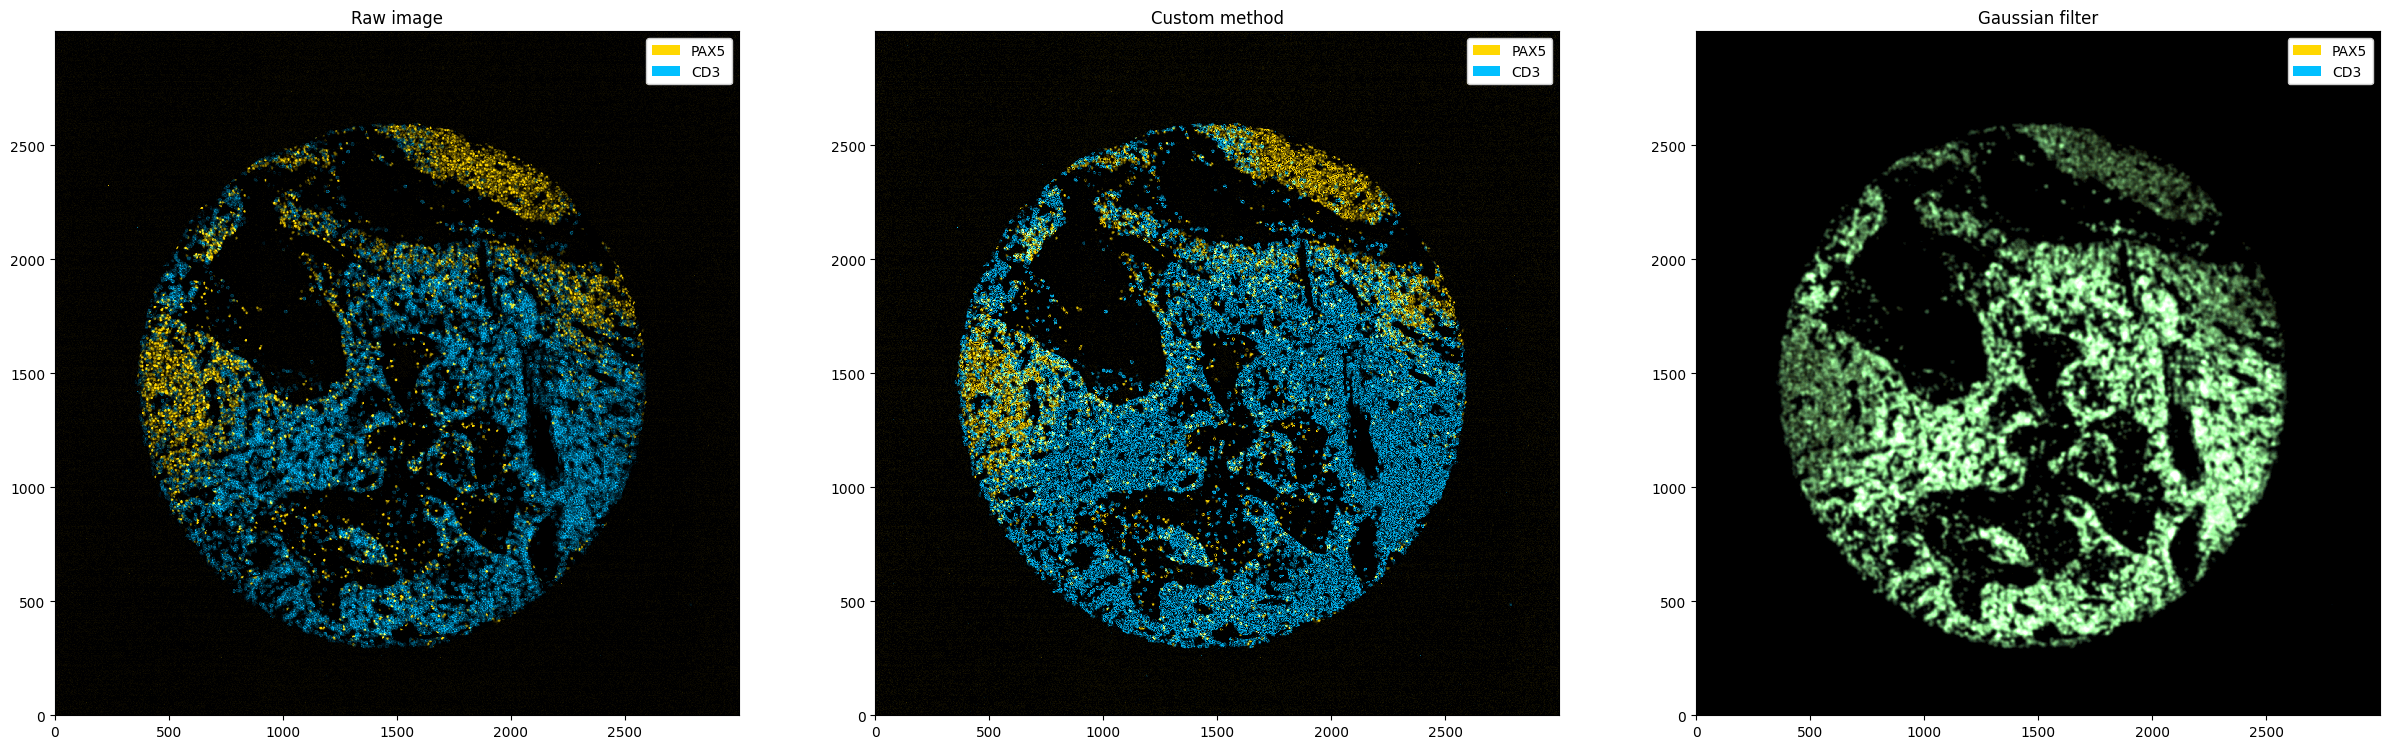

In [9]:
# application to multiple channels
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_multichannel.pl.colorize(['gold', 'deepskyblue']).pl.show(ax=ax[0])
_ = ds_multichannel.pp.apply(func=multiply_array).pl.colorize(['gold', 'deepskyblue']).pl.show(ax=ax[1])
_ = ds_multichannel.pp.apply(func=gaussian_filter, sigma=5).pl.colorize(['gold', 'deepskyblue']).pl.show(ax=ax[2])

ax[0].set_title("Raw image")
ax[1].set_title("Custom method")
ax[2].set_title("Gaussian filter")